In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
import seaborn as sns
import math
import re

from datetime import datetime
from Bio import SeqIO, Seq


from keras.models import Model
from keras.layers import Dense, Input, Lambda, Concatenate, LSTM, MaxPooling2D, Conv2D, Flatten

from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [2]:
from copy import deepcopy
from tqdm import tqdm

### Data preparation


In [3]:
aminoacids = []
dates      = []
countries  = []
for i in tqdm(SeqIO.parse('asdf/S_gene_aminoacids.fasta', 'fasta')):
    match = re.search(r'\d{4}-\d{2}-\d{2}', i.id)
    try:
        date = datetime.strptime(match.group(), '%Y-%m-%d').date()
        dates.append(date)
        aminoacids.append(str(Seq.translate(i.seq)))
        countries.append(re.sub(r'\/.*$','',re.sub(r'^.*?\/', '', i.id)))
    except:
        aminoacids.append('0')
        dates.append('0')
        countries.append('0')
    hello = deepcopy(i)
        
aminoacids = [x for x in aminoacids if x != '0']
dates = [x for x in dates if x != '0']
countries = [x for x in countries if x != '0']

70it [00:00, 688.60it/s]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/Bio/Seq.py:2742: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,
18728it [00:26, 705.88it/s]


#### Here we find unique 'characters' in the aminoacid chain, so that we can one hot encode them

In [4]:
unique_chars = list(set(aminoacids[0]))
for i, aminoacid in enumerate(aminoacids[1:]):
    new_chars = list(set(aminoacid))
    for char in new_chars:
        if char in unique_chars:
            continue
        else:
            unique_chars.append(char)

In [ ]:
print('The number of unique characters in the aminoacid chain is {}'.format(len(unique_chars)))

This makes sense as we have 20 standard aminoacids + stop sign.

In [5]:
a = {'aminoacids': aminoacids, 'dates': dates, 'country': countries}
df = pd.DataFrame(data=a)
df.dates = pd.to_datetime(df.dates)

/Users/igoradamski/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of samples in the data, by date')

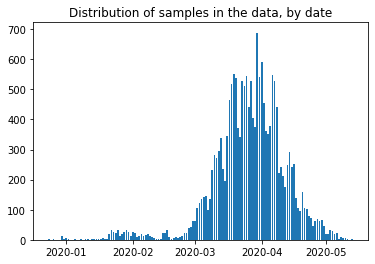

In [6]:
plt.bar(df.groupby(by = 'dates').count().index, df.groupby(by = 'dates').count()['aminoacids'])
plt.title('Distribution of samples in the data, by date')

In [7]:
print('The number of distinct dates is: {}'.format(len(df.groupby(by = 'dates').count().index)))

The number of distinct dates is: 131


In [8]:
print('The number of distinct countries is: {}'.format(len(df.groupby(by = 'country').count().index)))

The number of distinct countries is: 118


In [9]:
df['amino_length'] = df.apply(lambda row: len(row.aminoacids), axis = 1)

In [10]:
u, c = np.unique(np.array(df['amino_length']), return_counts = True)

In [11]:
u, c

(array([ 111,  113,  207, 1260, 1264, 1265, 1266, 1267, 1269, 1270, 1271,
        1272, 1273, 1274, 1275]),
 array([   12,     2,     1,     1,     1,     1,     1,     1,     1,
            4,     1,     2,    21, 18183,     3]))

For some reason the bar plot doesnt work on u and c, but anyway we can see that >99% of the aminoacids have length 1274, so in order to make the LSTM model easier to code (non variable feature space) **we only keep aminoacids with length 1274**.

In [12]:
df = df[df['amino_length'] == 1274]

### Now as discussed, we keep all the aminoacids in a given date (instead of taking unique) because we want the fact that some chains are more probable be represented

In [13]:
# If NOT then run this:

df = df.drop_duplicates()

### Commitment to architecture: we will treat each element of the aminoacid as a single datapoint. Its features will be a 22 long vector, first 21 items one-hot-encoding which letter it represents, the 22nd number being its position in the aminoacid chain. As we will train the LSTM we will randomly sample batches of these datapoints, bundled together in a time trajectory, with a randomly selected starting date. This will leave us with 18183*1274 = 23 165 142 datapoints so quite a number. We will train only on trajectories WITHIN the same country.

### Arbitrary division: we train on datapoints before 2020-04-10

In [14]:
df_train = df[df['dates'] < '2020-04-10']

In [15]:
print('The number of distinct dates is: {}'.format(len(df_train.groupby(by = 'dates').count().index)))

The number of distinct dates is: 98


### Another arbitrary decision, we will train the LSTM on trajectories (sequences) of length T, and we will train to predict the (T+1) timestep

In [16]:
T = 35

### Since we want to have sequences of at least T long, we remove countries that have less than T dates

In [17]:
countries = df_train.groupby('country')['dates'].nunique()
train_countries = countries[countries >= T].index.values

# Remove all other countries from df and recompute train_df
df = df[df['country'].isin(train_countries)]

df_train = df[df['dates'] < '2020-04-10']

In [18]:
print('The number of distinct dates is: {}'.format(len(df_train.groupby(by = 'dates').count().index)))

The number of distinct dates is: 76


In [19]:
print('The number of distinct countries is: {}'.format(len(df_train.groupby(by = 'country').count().index)))

The number of distinct countries is: 12


### Analysis of possible changes in the amino chains per country

In [20]:
unique_chains = {country:np.unique(df[df['country'] == country]['aminoacids']) for country in np.unique(df['country'])}

In [21]:
for country in unique_chains.keys():
    print('In {} there are {} unique chains'.format(country, len(unique_chains[country])))

In Australia there are 47 unique chains
In Belgium there are 27 unique chains
In Denmark there are 34 unique chains
In England there are 210 unique chains
In France there are 30 unique chains
In Germany there are 8 unique chains
In Netherlands there are 36 unique chains
In Scotland there are 78 unique chains
In Singapore there are 8 unique chains
In Spain there are 26 unique chains
In Taiwan there are 17 unique chains
In USA there are 215 unique chains


#### Lets now try and see where in the chain these changes happpen (on aggregate)

In [22]:
all_unique_chains = np.unique(df['aminoacids'])

chain_position_unique = {idx:0 for idx in range(len(all_unique_chains[0]))}

for idx in range(len(all_unique_chains[0])):
    nth_char = [chain[idx] for chain in all_unique_chains]
    chain_position_unique[idx] += len(np.unique(nth_char))

In [23]:
positions_with_no_change = []
positions_with_change    = []

for idx in chain_position_unique.keys():
    if chain_position_unique[idx] > 1:
        positions_with_change.append(idx)
    else:
        positions_with_no_change.append(idx)

In [24]:
print('Number of positions with no change is {}'.format(len(positions_with_no_change)))
print('Number of positions with at least 1 change is {}'.format(len(positions_with_change)))

Number of positions with no change is 904
Number of positions with at least 1 change is 370


#### It therefore seems logical to only consider the mutations of the positions in the list positions_with_change

### Change to architecture: now the features per datapoint will be 22 (as above) + 12, a one-hot representation of which country it is - maybe the virus evolves differently in different countries

### Code below makes life easier as we dont want to keep all 20 million datapoints lying in memory

In [25]:
class DataObject(object):

    def __init__(self, df, timesteps, positions, unique_chars):

        self.df        = df # pandas dataframe of the form as above
        self.timesteps = timesteps # number of timesteps (agreed above to T)
        
        self.positions = positions # Positions to consider
        
        self.unique_chars = unique_chars # List of unique characters encountered in the aminoacid
        
        # Compute stuff we dont want to compute all over again
        df = df.sort_values(by='dates')
        
        # Unique time steps
        self.time_list = np.unique(df['dates'])
        
        # Unique list of countries
        self.country_list = np.unique(df['country'])
        
        # Dictionary of one-hot encodings for country
        self.country_dict = {country:np.zeros(len(self.country_list)) for country in self.country_list}
        for i,country in enumerate(self.country_list):
           self.country_dict[country][i] = 1
        
        # Dictionary of one-hot encodings for aminoacid
        self.amino_dict = {char:np.zeros(len(self.unique_chars)) for char in self.unique_chars}
        for i,char in enumerate(self.unique_chars):
           self.amino_dict[char][i] = 1

    def generate_batch(self, batch_size):
        '''
        Here we generate a batch of trajectories.
        A Batch will be a matrix of size:
            (batch_size, timesteps, 22+countries)
        
            because we agreed on a 22+countries long representation of a amino entry
        '''        
        # We will put all countries in a batch
        dps_per_country = np.floor(batch_size*np.random.dirichlet([10]*len(self.country_list), 1))[0]
        err = batch_size - dps_per_country.sum()
        dps_per_country[np.argmax(dps_per_country)] += err
        
        for i, country in enumerate(self.country_list):
            temp_df        = df[df['country'] == country]
            temp_time_list = np.unique(temp_df['dates'])
            
            try:
                start_date = np.random.choice(temp_time_list[:-(timesteps+1)])
            except:
                start_date = temp_time_list[0]
                
            # This list contains one too many timesteps (because of need to fill target)
            temp_time_list = temp_time_list[(np.argwhere(temp_time_list == start_date)[0][0]):(np.argwhere(temp_time_list == start_date)[0][0] + (self.timesteps+1))]
            
            assert len(temp_time_list) == (self.timesteps+1), 'Something went wrong'
            
            batch_element  = np.zeros((int(dps_per_country[i]), self.timesteps, 22+len(self.country_list)))
            target_element = np.zeros((int(dps_per_country[i]), self.timesteps + 1, 21))
            
            # Now we need to sample positions
            positions = np.random.choice(self.positions, int(dps_per_country[i]))
            
            for i2, date in enumerate(temp_time_list):
                
                aminoacid = temp_df[temp_df['dates'] == date].sample() # this gives us random row from that date
                
                # Try to vectorize below loop, shouldnt be too hard
                #this_vec = np.append(np.array([self.amino_dict[aminoacid.iloc[0]['aminoacids'][position]] for position in positions]))
                
                for i3, position in enumerate(positions):
                    this_vec = np.append(self.amino_dict[aminoacid.iloc[0]['aminoacids'][position]], np.array([position]))
                    this_vec = np.append(this_vec, self.country_dict[country])
                    
                    if i2 < (len(temp_time_list)-1):
                        batch_element[i3,i2,:] = this_vec.astype(int)
                
                    target_element[i3,i2,:] = this_vec[:21].astype(int)
                
            if i == 0:
                batch  = batch_element
                target = target_element
            else:
                batch  = np.append(batch, batch_element, axis = 0)
                target = np.append(target, target_element, axis = 0)
            
            
        return np.array(batch).astype(float), np.array(target)[:,1:,:].astype(float)
    
class Batch(object):

    def __init__(self, data_object, batch_size):

        assert isinstance(data_object, DataObject), "Pass an instance of DataObject to Batch"
        
        self.all_data          = data_object
        self.batch_size        = batch_size
        self.data, self.target = data_object.generate_batch(batch_size)
        
    def __next__(self):
        
        self.data, self.target = self.all_data.generate_batch(self.batch_size)
        
        return self.data, self.target

    def __iter__(self):
        return self


In [26]:
igor = DataObject(df_train, T, positions_with_change, unique_chars)

In [27]:
batch = Batch(igor, 4)

# LSTM Model

### Im not that good with Tensorflow, so model building will infer shape from a batch we give it, but its not too hard to change it to variable shape

### We train on sequences that are 35 long, but trained model architecture will allow longer or shorter sequences (I think)

In [28]:
def build_3L_model(training_batch, hidden_layer_sizes = [512,256,128]):
    '''
    Builds a 3-lstm layer model, followed by a Dense classification layer
    '''
    batch_shape  = training_batch.data.shape
    target_shape = training_batch.target.shape
    
    model_input = Input(batch_shape = 
                          (batch_shape[0],  # batch_size
                           batch_shape[1],  # timesteps
                           batch_shape[2]),  # features
                          name="Input_layer")
    
    decoder = LSTM(units = hidden_layer_sizes[0],
                   dropout = 0.2, 
                   name = "Decoder_lstm_1",
                   return_sequences = True)(model_input)
    
    decoder = LSTM(units = hidden_layer_sizes[1],
                   dropout = 0.2, 
                   name = "Decoder_lstm_2",
                   return_sequences = True)(decoder)
    
    decoder = LSTM(units = hidden_layer_sizes[2],
                   dropout = 0.2, 
                   name = "Decoder_lstm_3",
                   return_sequences = True)(decoder)
    
    # Reshape so we can put everything through a last softmax layer
    # This is collecting batch + timesteps in one dimension
    decoder = Lambda(lambda x: tf.reshape(x, [-1,x.shape[2]]),
                    name = "Reshape_before_dense")(decoder)
    
    decoder = Dense(target_shape[-1], activation = 'softmax', 
                    name = 'Decoder_dense_1')(decoder)
    
    decoder = Lambda(lambda x: tf.reshape(x, [target_shape[0], target_shape[1], target_shape[2]]),
                    name = 'Final_reshape')(decoder)
    
    model = Model(model_input, decoder)
    
    return model

In [29]:
model = build_3L_model(batch)

In [30]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     (4, 35, 34)               0         
_________________________________________________________________
Decoder_lstm_1 (LSTM)        (4, 35, 512)              1120256   
_________________________________________________________________
Decoder_lstm_2 (LSTM)        (4, 35, 256)              787456    
_________________________________________________________________
Decoder_lstm_3 (LSTM)        (4, 35, 128)              197120    
_________________________________________________________________
Reshape_before_dense (Lambda (140, 128)                0         
_________________________________________________________________
Decoder_dense_1 (Dense)      (140, 21)                 2709      
_________________________________________________________________
Final_reshape (Lambda)       (4, 35, 21)               0   

In [ ]:
out = model.predict(batch.data)

# Train

In [ ]:
def my_binary_loss_seq(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 78])
    y_pred = tf.reshape(y_pred, [-1, 78])
    
    bce = tf.keras.losses.BinaryCrossentropy()
    
    return bce(y_true, y_pred)

def generate(train_batch):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        new_batch    = next(train_batch)
        #new_batch.target_split = 50
        new_batch.featurize(use_biaxial = True)
        yield ([tf.convert_to_tensor(new_batch.context, dtype = tf.float32), 
                tf.convert_to_tensor(new_batch.target_train, dtype = tf.float32)], 
               tf.convert_to_tensor(new_batch.target_pred, dtype = tf.float32))